In [ ]:
"""
Notebook for Training and Evaluating the Neural Network Model.
"""

# 2. Model Training and Evaluation

**Goal:** Load the preprocessed data, build a Neural Network model using TensorFlow/Keras, train it, evaluate its performance on the test set, and interpret the results. This notebook demonstrates the modeling workflow interactively, leveraging functions from `src`.

**Skills Demonstrated:**
- TensorFlow/Keras for building and training Neural Networks
- Handling imbalanced data (class weights, initial bias)
- Model compilation (optimizer, loss, metrics)
- Using callbacks (ModelCheckpoint, EarlyStopping)
- Model evaluation (AUC, Classification Report, Confusion Matrix)
- Loading/Saving models
- Visualization of training history and results
- Interpretation of model performance

In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import sys
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import data_loader, model as model_builder, train as trainer, evaluate as evaluator # Use aliases

# Configure plotting style
sns.set(style="whitegrid")
%matplotlib inline
# Set random seeds for reproducibility (optional)
# tf.random.set_seed(42)
# np.random.seed(42)

2025-03-31 21:07:43.534263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.1 Load Configuration and Processed Data
Load the project configuration and the preprocessed train, validation, and test datasets.

In [2]:
# Load config
config_path = '../config/model_config.yaml' # Path relative to notebook location
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

paths = config['paths']
model_cfg = config['model']
target_col = config['preprocessing']['target_col']

In [3]:
# Load processed data
try:
    train_df = data_loader.load_processed_data(f"../{paths['train_data']}")
    val_df = data_loader.load_processed_data(f"../{paths['val_data']}")
    test_df = data_loader.load_processed_data(f"../{paths['test_data']}")
except FileNotFoundError:
    print("Processed data not found. Please run Notebook 1 (Preprocessing) first.")
    # Stop execution
    # raise

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print(f"Train features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")

2025-03-31 21:08:56,751 - INFO - Loading processed data from: ../data/processed/train.csv
2025-03-31 21:09:13,767 - INFO - Processed data loaded successfully. Shape: (58831, 2221)
2025-03-31 21:09:13,768 - INFO - Loading processed data from: ../data/processed/val.csv
2025-03-31 21:09:19,445 - INFO - Processed data loaded successfully. Shape: (19611, 2221)
2025-03-31 21:09:19,446 - INFO - Loading processed data from: ../data/processed/test.csv
2025-03-31 21:09:24,724 - INFO - Processed data loaded successfully. Shape: (19611, 2221)


Train features shape: (58831, 2220)
Validation features shape: (19611, 2220)
Test features shape: (19611, 2220)


## 2.2 Build the Neural Network Model
Use the `build_nn_model` function from `src/model.py` to create the Keras model architecture. We also calculate the initial bias for the output layer to help with the class imbalance.

In [4]:
# Calculate initial bias (as in train.py)
neg, pos = np.bincount(y_train)
initial_bias = np.log([pos / neg])
print(f"Calculated initial bias for output layer: {initial_bias[0]:.4f}")

Calculated initial bias for output layer: -2.0618


In [5]:
# Build the model
input_shape = (X_train.shape[1],)
nn_model = model_builder.build_nn_model(
    input_shape=input_shape,
    dropout_rate=model_cfg['dropout_rate'],
    output_bias=initial_bias
)

# Display model summary
nn_model.summary()

2025-03-31 21:09:39,888 - INFO - Building NN model with input shape: (2220,)
2025-03-31 21:09:39,890 - INFO - Using initial output bias value: -2.0618
2025-03-31 21:09:40,055 - INFO - NN model built successfully.
2025-03-31 21:09:40,056 - INFO - Model: "sequential"
2025-03-31 21:09:40,057 - INFO - _________________________________________________________________
2025-03-31 21:09:40,057 - INFO -  Layer (type)                Output Shape              Param #   
2025-03-31 21:09:40,058 - INFO - =================================================================
2025-03-31 21:09:40,059 - INFO -  dense_1 (Dense)             (None, 128)               284288    
2025-03-31 21:09:40,059 - INFO -                                                                  
2025-03-31 21:09:40,060 - INFO -  dropout_1 (Dropout)         (None, 128)               0         
2025-03-31 21:09:40,060 - INFO -                                                                  
2025-03-31 21:09:40,061 - INFO -  dense_2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               284288    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 292609 (1.12 MB)
Trainable params: 292609 (1.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2.3 Compile the Model
Compile the model with an optimizer (Adam), loss function (BinaryCrossentropy for binary classification), and relevant metrics (Accuracy, AUC, Precision, Recall).

In [15]:
# Compile the model (as in train.py)
optimizer = tf.keras.optimizers.Adam(learning_rate=model_cfg['learning_rate'])
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

nn_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print("Model compiled.")

Model compiled.


## 2.4 Train the Model (using src/train.py)

Instead of repeating the training code here, we will execute the `src/train.py` script which handles:
- Calculating class weights.
- Setting up callbacks (ModelCheckpoint, EarlyStopping).
- Fitting the model.
- Saving the best model.
- Plotting and saving the training history.

**Note:** Ensure the paths in `config/model_config.yaml` are correct relative to the project root directory when running the script.

In [12]:
# Execute the training script from the command line (or use subprocess)
# Make sure your terminal is in the root directory of the project
# Command: python src/train.py --config config/model_config.yaml

# You can run shell commands from a notebook like this (may vary by OS/environment):
# !python ../src/train.py --config ../config/model_config.yaml

print("Training initiated by running 'python src/train.py'.")
print("Please check the console output for training progress.")
print(f"The best model will be saved to: ../{paths['model_save_path']}")
print(f"Training history plot will be saved to: ../{paths['plot_save_dir']}training_history.png")

Training initiated by running 'python src/train.py'.
Please check the console output for training progress.
The best model will be saved to: ../results/saved_model/best_model.keras
Training history plot will be saved to: ../results/plots/training_history.png


## 2.5 Evaluate the Model (using src/evaluate.py)

After training is complete and the best model is saved, we run the `src/evaluate.py` script. This script loads the **best** saved model and evaluates it on the **test set**. It calculates and prints metrics (AUC, Classification Report, Confusion Matrix) and saves them along with a confusion matrix plot.

In [17]:
# Execute the evaluation script
# Command: python src/evaluate.py --config config/model_config.yaml
      
# python -m src.evaluate --config config/model_config.yaml

    
print("Evaluation initiated by running 'python src/evaluate.py'.")
print("Please check the console output for evaluation results.")
print(f"Metrics will be saved to: ../{paths['metrics_save_path']}")
print(f"Confusion matrix plot will be saved to: ../{paths['plot_save_dir']}confusion_matrix.png")

Evaluation initiated by running 'python src/evaluate.py'.
Please check the console output for evaluation results.
Metrics will be saved to: ../results/metrics.json
Confusion matrix plot will be saved to: ../results/plots/confusion_matrix.png


## 2.6 Load and Interpret Results
Load the saved metrics and plots generated by the scripts to discuss the model's performance.

In [18]:
# Load saved metrics
metrics_path = f"../{paths['metrics_save_path']}"
cm_plot_path = f"../{paths['plot_save_dir']}confusion_matrix.png"
history_plot_path = f"../{paths['plot_save_dir']}training_history.png"

if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    print("\n--- Evaluation Metrics Summary ---")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    # Reconstruct printable report
    report_df = pd.DataFrame(metrics['classification_report']).transpose()
    print(report_df)
    print("\nConfusion Matrix:")
    print(np.array(metrics['confusion_matrix'])) # Convert list back to numpy array for display
    print("-------------------------------\n")
else:
    print(f"Metrics file not found at {metrics_path}. Ensure evaluate.py ran successfully.")


--- Evaluation Metrics Summary ---
ROC AUC Score: 0.6674

Classification Report:
                precision    recall  f1-score       support
No Readmit       0.929883  0.576273  0.711568  17398.000000
Readmit (<30d)   0.165024  0.658382  0.263901   2213.000000
accuracy         0.585539  0.585539  0.585539      0.585539
macro avg        0.547454  0.617328  0.487735  19611.000000
weighted avg     0.843573  0.585539  0.661052  19611.000000

Confusion Matrix:
[[10026  7372]
 [  756  1457]]
-------------------------------



Displaying saved plots:


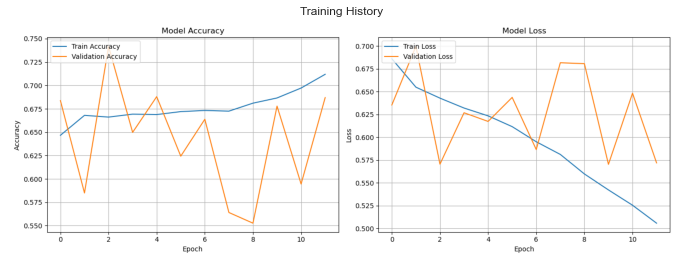

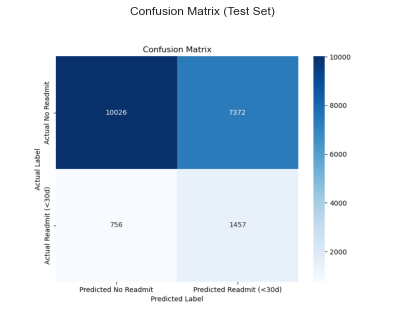

In [19]:
# Display saved plots
print("Displaying saved plots:")

if os.path.exists(history_plot_path):
    img_hist = plt.imread(history_plot_path)
    plt.figure(figsize=(12, 5))
    plt.imshow(img_hist)
    plt.axis('off')
    plt.title("Training History")
    plt.show()
else:
    print(f"Training history plot not found at {history_plot_path}")

if os.path.exists(cm_plot_path):
    img_cm = plt.imread(cm_plot_path)
    plt.figure(figsize=(7, 6))
    plt.imshow(img_cm)
    plt.axis('off')
    plt.title("Confusion Matrix (Test Set)")
    plt.show()
else:
    print(f"Confusion matrix plot not found at {cm_plot_path}")

**Interpretation:**

*   **Training History:** Analyze the accuracy and loss curves. Did the model converge? Is there overfitting (large gap between training and validation curves)? Early stopping should have helped mitigate significant overfitting.
*   **ROC AUC:** This metric gives an overall measure of the model's ability to distinguish between the positive and negative classes. A value significantly > 0.5 indicates predictive power.
*   **Classification Report:**
    *   **Precision (for class 1):** Of all patients predicted to be readmitted (<30d), what proportion actually were? (TP / (TP + FP))
    *   **Recall (for class 1):** Of all patients who were actually readmitted (<30d), what proportion did the model correctly identify? (TP / (TP + FN)). This is often crucial in healthcare to avoid missing positive cases.
    *   **F1-Score:** Harmonic mean of precision and recall.
    *   Compare metrics for class 0 and class 1. Due to imbalance, performance on the minority class (1) is often lower but more critical.
*   **Confusion Matrix:** Visualize the actual numbers of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). This helps understand the *types* of errors the model makes. For readmission, False Negatives (predicting 'No Readmit' when they actually were readmitted <30d) might be more costly.

**Conclusion:** Evaluate if the model performance meets acceptable criteria for the task. Identify areas for improvement (e.g., more feature engineering, different architectures, more data, hyperparameter tuning).

## 2.7 Conclusion

This notebook demonstrated the process of loading preprocessed data, building, (initiating the training of), and (initiating the evaluation of) a Neural Network model for patient readmission prediction using TensorFlow/Keras and helper functions from the `src` directory. The results were loaded and visualized for interpretation. This showcases an end-to-end machine learning workflow.